# Project 2 -- All 5 Categories

In [2]:
from ultralytics import YOLO
from roboflow import Roboflow
import os
import matplotlib.pyplot as plt
from PIL import Image
from shuffle import train_test_split
import pydoc

In [3]:

def path_to(*p):
    """
    Takes an arbitrary number of strings and converts it to a path
    with the current working directory automatically tacked onto the front of the path.
    
    Parameters:
        *p (str): Single string or list of strings.
    
    Returns:
        (string): Full path to desired directory/file
    """
    return os.path.join(os.getcwd(), *p)

## Download dataset form Roboflow
For this to work you must update with your own API key. This is only necessary if you want to train it yourself.

In [4]:
def download_dataset(v: int):
    """
    Function that takes the dataset version and downloads if from our Roboflow Project.
    The dataset will be save under project2-dataset-{v}.
    
    Parameters:
        v (int): the version number of the dataset that you want to download
    Returns: 
        None: This function does not return anything.
        
    """
    rf = Roboflow(api_key="jSHmBYOVLG3O81wzzHz3")
    project = rf.workspace("pikavision").project("project2-dataset")
    version = project.version(v)
    dataset = version.download("yolov11")
download_dataset(3)

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to project2-dataset-3 in yolov11:: 100%|██████████| 19466/19466 [00:01<00:00, 18476.83it/s]


### Split the data
This splits the data into train, valid, and test datasets at random. 

85% train, 10% validation, 5% test

In [6]:
# Split data into train validation and dest datasets
train_test_split(path_to('project2-dataset-5', 'train'), percentage_test=5, percentage_valid=10)

Total images in src directory: 19460
image-190-_jpg.rf.7cbb9e913d5097add0babee6ce8369ea
foto04844_jpg.rf.67228c816620165c8a7f234c94b2760e
Maine_Coon_160_jpg.rf.57420dc5dc1a1eeace79eb9ff5116cff
basset_hound_137_jpg.rf.740867f04834242a3f620db36b42bbde
image-408-_jpg.rf.b7a957fbefa747ff9e194237c1583154
image-12-_jpg.rf.6776f891360ab2621a83f4bed28eea65
havanese_13_jpg.rf.e8dcf8dddba89f8599289111f43e009e
Siamese_175_jpg.rf.ad222b81ce9740eaa069004269a0e902
image-827-_jpg.rf.f34516992723b9486656c7914f6d0503
image-636-_jpg.rf.5a6cda6c2ba82c0e06354eaa22309784
pikachu_00600_jpg.rf.ba85c8888b5efa67c7beb23367416655
english_setter_15_jpg.rf.4acc54a9a61c3b0e399baea9ffbf6e4b
image-119-_jpg.rf.f517c2d1911d8223337389a1bb3b68aa
beagle_105_jpg.rf.d1cff11f756dc83de82f8d7c9c48ddf0
pic_501_jpg.rf.d33678859a45cdb6814e004fa67171ac
image-616-_jpg.rf.777df148d415a533e23f7e491a01f45f
image-802-_jpg.rf.26474b375d4beb0245643208124a87ec
image-503-_jpg.rf.3a02ce9ed8a1bd43d0b0bc7cdef195d8
american_bulldog_136_jpg.rf.

## Test Model Function

Takes the model and a sample image and saves new photo with prediction(s) and bounding boxes.

In [ ]:
def test_model(model : YOLO, sample_image : str):
    """
    Takes the model and a sample image and then produces a prediction image.
    The function saves the image to the test_images folder.
    It also shows the predictions using matplotlib.
    
    Parameters:
        model (YOLO): YOLO model that you want to make a prediction with.
        sample_image (str): Sample image to make the prediction on. Can by .png or .jpg
    
    Returns:
        None: This function does not return any value.

    """
    path_to_img = path_to('test_images', sample_image)
    results = model.predict(
        source=path_to_img,
        conf=0.1,
    )

    for r in results:
        name = 'the_detected_' + sample_image
        path_to_predicted_img = path_to('test_images', name)
        r.save(path_to_predicted_img)
    image = Image.open(path_to_predicted_img)
    plt.imshow(image)
    plt.axis('off')
    plt.show()
        

## Train the model 
Takes model and new data. Uses "Transfer Learning" to add/improve category(s) based on new data given. 

In [ ]:
def train_model(model : YOLO, yaml_file : str) -> YOLO:
    """
    Takes the model and a .yaml file and trains the model on the dataset specified in the .yaml file.
    Saves the results of the training to runs/detect
    
    Parameters:
        model (YOLO): The pretrained model that you want want to train ontop of. 
        yaml_file (str): The .yaml file that specifies the data that you want to train on.
        
    Returns: 
        None: This function does not return anything.
    """
    results = model.train(
        data = path_to('project2-dataset-5', yaml_file),
        epochs = 100,
        imgsz = 640,
        save_dir = path_to(),
        device = 'gpu',
        batch=16
        
    )
    

### Load pretrained model
This loads the YOLOv11 model as a starting point

In [9]:
model = YOLO('yolo11n.pt')


image 1/1 /home/hunt3041/PikaVision/test_images/the_cat.png: 384x640 1 cat, 39.6ms
Speed: 2.8ms preprocess, 39.6ms inference, 87.5ms postprocess per image at shape (1, 3, 384, 640)


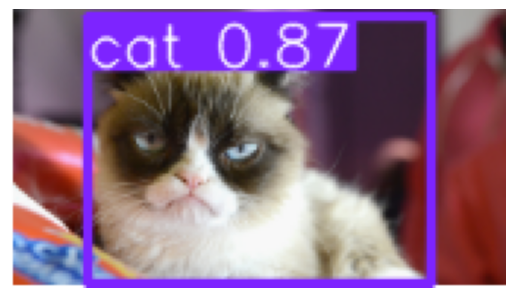


image 1/1 /home/hunt3041/PikaVision/test_images/the_dog.png: 416x640 1 dog, 39.8ms
Speed: 0.9ms preprocess, 39.8ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 640)


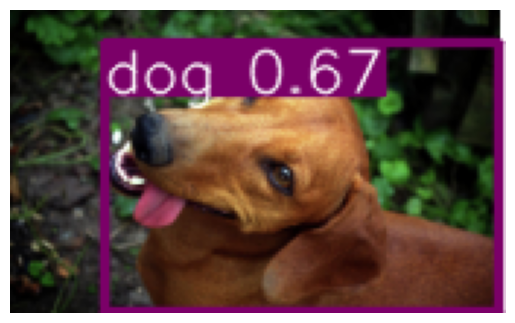


image 1/1 /home/hunt3041/PikaVision/test_images/the_drone.jpg: 384x640 1 airplane, 5.4ms
Speed: 1.0ms preprocess, 5.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


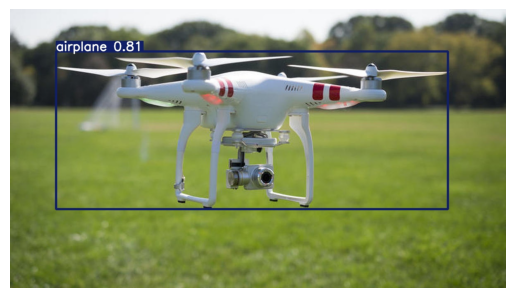


image 1/1 /home/hunt3041/PikaVision/test_images/the_person.png: 448x640 2 persons, 38.9ms
Speed: 1.0ms preprocess, 38.9ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


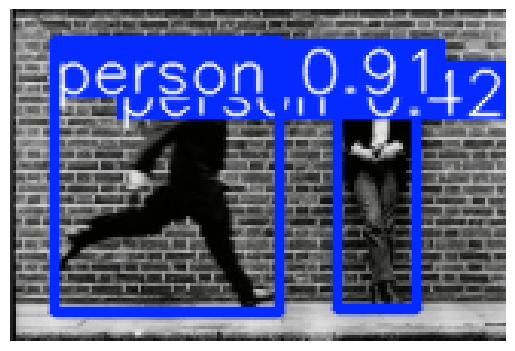


image 1/1 /home/hunt3041/PikaVision/test_images/the_pikachu.jpeg: 320x640 1 teddy bear, 52.0ms
Speed: 0.9ms preprocess, 52.0ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)


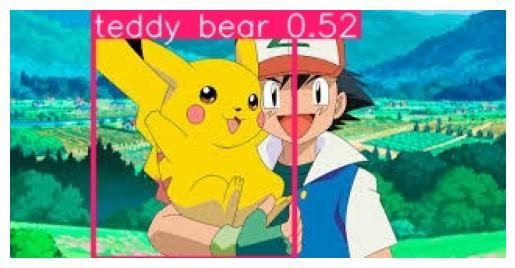

In [10]:
# Test the pretrained model
test_model(model, 'the_cat.png')
test_model(model, 'the_dog.png')
test_model(model, 'the_drone.jpg')
test_model(model, 'the_person.png')
test_model(model, 'the_pikachu.jpeg') 

In [11]:
train_model(model, 'data.yaml')

Ultralytics 8.3.34 🚀 Python-3.8.10 torch-2.4.1+cu121 CUDA:gpu (NVIDIA GeForce RTX 3060, 12288MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/home/hunt3041/PikaVision/project2-dataset-5/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=gpu, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, 

train: Scanning /home/hunt3041/PikaVision/project2-dataset-5/train/labels... 16541 images, 2027 backgrounds, 0 corrupt: 100%|██████████| 16541/16541 [00:11<00:00, 1382.72it/s]


train: New cache created: /home/hunt3041/PikaVision/project2-dataset-5/train/labels.cache


val: Scanning /home/hunt3041/PikaVision/project2-dataset-5/valid/labels... 1946 images, 241 backgrounds, 0 corrupt: 100%|██████████| 1946/1946 [00:01<00:00, 1186.04it/s]

val: New cache created: /home/hunt3041/PikaVision/project2-dataset-5/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.45G      2.253      3.647       2.38         22        640: 100%|██████████| 1034/1034 [02:25<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:09<00:00,  6.40it/s]


                   all       1946       2115      0.497      0.448      0.419      0.197

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.39G      1.512      2.278      1.803         43        640: 100%|██████████| 1034/1034 [02:19<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:09<00:00,  6.28it/s]


                   all       1946       2115      0.724      0.634      0.707       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.38G      1.382       1.86      1.678         24        640: 100%|██████████| 1034/1034 [02:16<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:09<00:00,  6.46it/s]


                   all       1946       2115      0.692      0.644      0.687      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.37G      1.323      1.697      1.616         45        640: 100%|██████████| 1034/1034 [02:17<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:09<00:00,  6.51it/s]

                   all       1946       2115      0.757      0.681      0.744      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.39G       1.27      1.569      1.566         25        640: 100%|██████████| 1034/1034 [02:16<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:09<00:00,  6.45it/s]

                   all       1946       2115      0.811      0.725      0.806      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.37G      1.224      1.465      1.524         35        640: 100%|██████████| 1034/1034 [02:15<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:09<00:00,  6.63it/s]

                   all       1946       2115      0.817      0.771      0.832      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.38G      1.193      1.396      1.496         27        640: 100%|██████████| 1034/1034 [02:11<00:00,  7.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:09<00:00,  6.33it/s]

                   all       1946       2115      0.831      0.774      0.837      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.36G      1.163      1.341       1.48         23        640: 100%|██████████| 1034/1034 [02:17<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:09<00:00,  6.40it/s]

                   all       1946       2115      0.879      0.781      0.862      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.39G      1.149      1.292      1.463         35        640: 100%|██████████| 1034/1034 [02:15<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:09<00:00,  6.65it/s]

                   all       1946       2115      0.865      0.797      0.872      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.38G      1.126      1.263      1.446         26        640: 100%|██████████| 1034/1034 [02:19<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:10<00:00,  6.09it/s]

                   all       1946       2115       0.88      0.816      0.881      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.37G      1.107      1.225      1.427         26        640: 100%|██████████| 1034/1034 [02:17<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:09<00:00,  6.32it/s]

                   all       1946       2115      0.871      0.813      0.884      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.37G      1.099      1.192      1.424         30        640: 100%|██████████| 1034/1034 [02:19<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:09<00:00,  6.29it/s]

                   all       1946       2115      0.879      0.829      0.895      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.39G      1.083      1.171      1.409         26        640: 100%|██████████| 1034/1034 [02:14<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.55it/s]

                   all       1946       2115       0.89      0.839        0.9      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.37G      1.069      1.136      1.396         45        640: 100%|██████████| 1034/1034 [02:04<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:09<00:00,  6.70it/s]

                   all       1946       2115      0.898      0.842      0.902      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.37G      1.057      1.125      1.391         28        640: 100%|██████████| 1034/1034 [02:06<00:00,  8.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  6.83it/s]

                   all       1946       2115      0.891      0.858      0.906      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.42G      1.047      1.101      1.378         24        640: 100%|██████████| 1034/1034 [02:04<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.18it/s]

                   all       1946       2115      0.915      0.841      0.909      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.43G      1.039      1.085      1.371         30        640: 100%|██████████| 1034/1034 [02:06<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:09<00:00,  6.52it/s]

                   all       1946       2115      0.918      0.849       0.91      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100       2.4G      1.043      1.076      1.373         26        640: 100%|██████████| 1034/1034 [02:04<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.26it/s]

                   all       1946       2115      0.911      0.856      0.916      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100       2.4G      1.029      1.059      1.363         18        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.35it/s]

                   all       1946       2115      0.904      0.869      0.921        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.36G      1.024      1.039      1.357         33        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.13it/s]

                   all       1946       2115       0.91      0.858      0.918      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.39G      1.009      1.025      1.347         20        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.55it/s]

                   all       1946       2115      0.936      0.867      0.929      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.37G     0.9952       1.01      1.334         27        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.27it/s]

                   all       1946       2115      0.911      0.878      0.926      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.37G          1      1.008      1.342         25        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.42it/s]

                   all       1946       2115      0.922      0.878      0.927      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.37G     0.9969     0.9963      1.339         28        640: 100%|██████████| 1034/1034 [02:04<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.31it/s]

                   all       1946       2115      0.934       0.88      0.932      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.37G     0.9844     0.9813      1.328         27        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.44it/s]

                   all       1946       2115      0.927      0.891      0.938      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.37G     0.9794     0.9763      1.325         24        640: 100%|██████████| 1034/1034 [02:04<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:09<00:00,  6.72it/s]

                   all       1946       2115      0.934      0.877      0.936      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.37G     0.9777     0.9662      1.322         24        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.52it/s]

                   all       1946       2115      0.928      0.894      0.939      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.36G      0.967     0.9508      1.316         40        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.14it/s]

                   all       1946       2115      0.946      0.883      0.939      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.42G     0.9624     0.9399      1.315         29        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  6.82it/s]

                   all       1946       2115      0.933       0.89      0.939      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.36G     0.9645     0.9398      1.311         31        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.20it/s]

                   all       1946       2115      0.929        0.9      0.943      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.37G     0.9614      0.929       1.31         28        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.18it/s]

                   all       1946       2115      0.943      0.894      0.943      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.37G      0.955     0.9259      1.306         43        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.60it/s]

                   all       1946       2115      0.934      0.905      0.945      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.37G     0.9481     0.9149      1.301         26        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.37it/s]

                   all       1946       2115      0.934      0.908      0.947       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.39G      0.942      0.908      1.296         26        640: 100%|██████████| 1034/1034 [02:05<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.23it/s]

                   all       1946       2115      0.944      0.903      0.947       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.37G     0.9406     0.8986      1.295         25        640: 100%|██████████| 1034/1034 [02:04<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  6.97it/s]

                   all       1946       2115      0.939       0.91       0.95      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.37G     0.9295     0.8856      1.284         30        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.45it/s]

                   all       1946       2115      0.945      0.908      0.949      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.39G     0.9323     0.8867      1.288         28        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:09<00:00,  6.70it/s]

                   all       1946       2115      0.944      0.901      0.949      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.36G     0.9237      0.884      1.285         21        640: 100%|██████████| 1034/1034 [02:04<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.47it/s]

                   all       1946       2115       0.94      0.912       0.95      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.37G     0.9214     0.8648      1.282         26        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:07<00:00,  7.74it/s]

                   all       1946       2115      0.943      0.907      0.949      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.37G     0.9174     0.8635      1.277         20        640: 100%|██████████| 1034/1034 [02:04<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:09<00:00,  6.75it/s]

                   all       1946       2115      0.942      0.904      0.951       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100       2.4G     0.9104     0.8626      1.275         21        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.37it/s]

                   all       1946       2115      0.942       0.91      0.951      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100       2.4G      0.913     0.8444      1.273         35        640: 100%|██████████| 1034/1034 [02:04<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.45it/s]

                   all       1946       2115      0.953       0.91      0.953      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.39G     0.9008     0.8383      1.267         35        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.48it/s]

                   all       1946       2115      0.945      0.915      0.953      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.39G     0.9001     0.8361      1.266         35        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.27it/s]

                   all       1946       2115      0.946      0.917      0.952      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.37G     0.8995     0.8351      1.263         32        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.37it/s]

                   all       1946       2115      0.952      0.911      0.954      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.35G     0.8939     0.8286       1.26         34        640: 100%|██████████| 1034/1034 [02:04<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.54it/s]

                   all       1946       2115      0.956      0.909      0.956       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.42G     0.8952     0.8261      1.261         28        640: 100%|██████████| 1034/1034 [02:02<00:00,  8.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.55it/s]

                   all       1946       2115      0.955      0.911      0.955      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.35G     0.8782     0.8136       1.25         29        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.33it/s]

                   all       1946       2115      0.956      0.912      0.956      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.37G     0.8783     0.8039      1.253         31        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.48it/s]

                   all       1946       2115       0.96      0.913      0.956      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.35G     0.8871     0.8084      1.254         25        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.32it/s]

                   all       1946       2115      0.961      0.911      0.957      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.42G     0.8777     0.7913      1.246         24        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:07<00:00,  7.74it/s]

                   all       1946       2115      0.959      0.915      0.957      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.35G     0.8727      0.791      1.243         28        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.55it/s]

                   all       1946       2115      0.957      0.916      0.957      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.37G     0.8671     0.7894      1.241         24        640: 100%|██████████| 1034/1034 [02:02<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:07<00:00,  7.69it/s]

                   all       1946       2115      0.958      0.914      0.957      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.39G     0.8684     0.7898      1.244         33        640: 100%|██████████| 1034/1034 [02:02<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.20it/s]

                   all       1946       2115      0.961      0.915      0.958       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.37G     0.8651     0.7776      1.239         30        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.23it/s]

                   all       1946       2115      0.964      0.915      0.959       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.37G     0.8634     0.7682      1.234         29        640: 100%|██████████| 1034/1034 [02:04<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.27it/s]

                   all       1946       2115      0.964      0.916       0.96      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.37G     0.8534     0.7651      1.233         25        640: 100%|██████████| 1034/1034 [02:04<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.44it/s]

                   all       1946       2115      0.961      0.918       0.96      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.39G     0.8528     0.7609      1.231         36        640: 100%|██████████| 1034/1034 [02:06<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.60it/s]

                   all       1946       2115       0.96      0.919       0.96      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.37G     0.8489     0.7604      1.229         25        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.31it/s]

                   all       1946       2115       0.96       0.92       0.96      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.37G      0.846     0.7534      1.226         31        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.35it/s]

                   all       1946       2115      0.958      0.923       0.96      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.37G     0.8381     0.7448      1.223         19        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.28it/s]

                   all       1946       2115      0.959      0.925      0.962      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.35G     0.8399     0.7436      1.223         34        640: 100%|██████████| 1034/1034 [02:05<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.51it/s]

                   all       1946       2115      0.961      0.924      0.962      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.39G     0.8393     0.7369      1.219         26        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.11it/s]

                   all       1946       2115       0.96      0.925      0.962      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.35G     0.8257     0.7236      1.213         27        640: 100%|██████████| 1034/1034 [02:04<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.29it/s]

                   all       1946       2115       0.96      0.925      0.962        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.37G     0.8321     0.7331      1.216         26        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:07<00:00,  7.64it/s]

                   all       1946       2115       0.96      0.926      0.963      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.39G     0.8225     0.7161      1.212         26        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.52it/s]

                   all       1946       2115      0.959      0.926      0.963      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.37G     0.8254     0.7186      1.211         29        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  6.93it/s]

                   all       1946       2115      0.962      0.922      0.964      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.37G     0.8249     0.7158      1.211         30        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.56it/s]

                   all       1946       2115       0.96      0.923      0.964      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.37G     0.8205     0.7035      1.205         32        640: 100%|██████████| 1034/1034 [02:05<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:09<00:00,  6.66it/s]

                   all       1946       2115       0.96      0.923      0.964      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.38G     0.8079     0.6933      1.201         29        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.24it/s]

                   all       1946       2115      0.962      0.922      0.964      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.37G     0.8099     0.6952      1.202         38        640: 100%|██████████| 1034/1034 [02:04<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:09<00:00,  6.61it/s]

                   all       1946       2115      0.962      0.922      0.964      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.37G     0.8101     0.6942      1.207         22        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.06it/s]

                   all       1946       2115      0.962      0.923      0.964      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.37G     0.7991     0.6801      1.194         28        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.18it/s]

                   all       1946       2115      0.962      0.925      0.965      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.35G     0.7966     0.6804      1.193         24        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:07<00:00,  7.68it/s]

                   all       1946       2115      0.961      0.925      0.965      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.37G     0.7902     0.6819      1.191         26        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.33it/s]

                   all       1946       2115      0.962      0.923      0.965      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.39G     0.7888     0.6671      1.187         23        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.35it/s]

                   all       1946       2115      0.963      0.921      0.965      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.37G      0.783     0.6625       1.18         28        640: 100%|██████████| 1034/1034 [02:04<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.20it/s]

                   all       1946       2115      0.965      0.922      0.965      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.39G     0.7869     0.6608      1.185         37        640: 100%|██████████| 1034/1034 [02:04<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.48it/s]

                   all       1946       2115      0.965      0.923      0.965      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.37G     0.7732     0.6519      1.177         28        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.22it/s]

                   all       1946       2115      0.966      0.923      0.966      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.37G     0.7739     0.6471      1.176         30        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.20it/s]

                   all       1946       2115      0.966      0.924      0.966      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.37G     0.7705     0.6429      1.174         25        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.43it/s]

                   all       1946       2115      0.967      0.923      0.966      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.37G     0.7662     0.6363       1.17         30        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.02it/s]

                   all       1946       2115      0.966      0.924      0.966      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.37G     0.7633     0.6318      1.171         27        640: 100%|██████████| 1034/1034 [02:04<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.32it/s]

                   all       1946       2115      0.966      0.925      0.966       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.39G     0.7611     0.6375       1.17         28        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.23it/s]

                   all       1946       2115      0.967      0.924      0.966       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.37G     0.7576     0.6314      1.166         35        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.17it/s]

                   all       1946       2115      0.967      0.923      0.967       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.37G      0.754     0.6214      1.165         28        640: 100%|██████████| 1034/1034 [02:04<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.44it/s]

                   all       1946       2115      0.967      0.923      0.967      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.37G     0.7563      0.625      1.169         31        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  6.99it/s]

                   all       1946       2115      0.968      0.923      0.967      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.35G     0.7492      0.612       1.16         31        640: 100%|██████████| 1034/1034 [02:04<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.16it/s]

                   all       1946       2115      0.969      0.923      0.967      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.37G      0.743     0.6085      1.156         27        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.44it/s]

                   all       1946       2115       0.97      0.924      0.967      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.35G     0.7397     0.5998       1.15         29        640: 100%|██████████| 1034/1034 [02:05<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.16it/s]

                   all       1946       2115       0.97      0.923      0.967      0.811


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.37G     0.6305     0.3992      1.099         13        640: 100%|██████████| 1034/1034 [02:05<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.21it/s]

                   all       1946       2115      0.969      0.923      0.967      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.35G     0.6122     0.3809      1.085         16        640: 100%|██████████| 1034/1034 [02:04<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.46it/s]

                   all       1946       2115      0.969      0.924      0.967      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.37G     0.6021     0.3681       1.08         13        640: 100%|██████████| 1034/1034 [02:04<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.12it/s]

                   all       1946       2115       0.97      0.924      0.968      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.35G     0.5971      0.366      1.077         17        640: 100%|██████████| 1034/1034 [02:05<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.34it/s]

                   all       1946       2115       0.97      0.924      0.968      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.37G     0.5928     0.3601      1.073         10        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.51it/s]

                   all       1946       2115       0.97      0.924      0.968      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.35G     0.5836     0.3509      1.065         14        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.55it/s]

                   all       1946       2115       0.97      0.924      0.968      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.37G     0.5841     0.3489      1.066         14        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.05it/s]

                   all       1946       2115      0.968      0.925      0.968      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.36G      0.576     0.3439      1.063         12        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.33it/s]

                   all       1946       2115      0.969      0.925      0.968      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.37G      0.571     0.3396      1.056         16        640: 100%|██████████| 1034/1034 [02:02<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.56it/s]

                   all       1946       2115      0.969      0.925      0.969      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.35G     0.5653     0.3345      1.053         13        640: 100%|██████████| 1034/1034 [02:03<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.57it/s]

                   all       1946       2115      0.969      0.925      0.968      0.818



100 epochs completed in 3.736 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.34 🚀 Python-3.8.10 torch-2.4.1+cu121 CUDA:gpu (NVIDIA GeForce RTX 3060, 12288MiB)
YOLO11n summary (fused): 238 layers, 2,583,127 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:08<00:00,  7.13it/s]


                   all       1946       2115      0.969      0.925      0.968      0.818
                   cat        254        257      0.991      0.992      0.994       0.93
                   dog        495        495      0.988      0.986      0.994      0.861
                 drone        469        499      0.976      0.971      0.991      0.709
                person        357        728      0.933      0.758      0.896      0.741
               pikachu        130        136      0.958      0.919      0.967      0.849
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train



image 1/1 /home/hunt3041/PikaVision/test_images/the_cat.png: 384x640 1 cat, 36.6ms
Speed: 3.5ms preprocess, 36.6ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


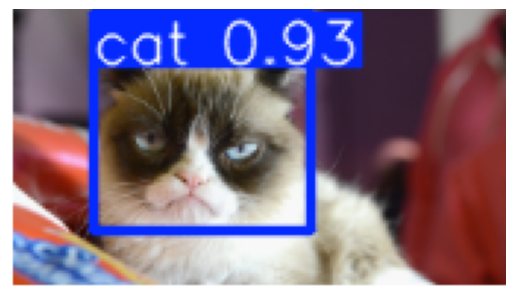


image 1/1 /home/hunt3041/PikaVision/test_images/the_dog.png: 416x640 1 dog, 62.6ms
Speed: 2.8ms preprocess, 62.6ms inference, 2.8ms postprocess per image at shape (1, 3, 416, 640)


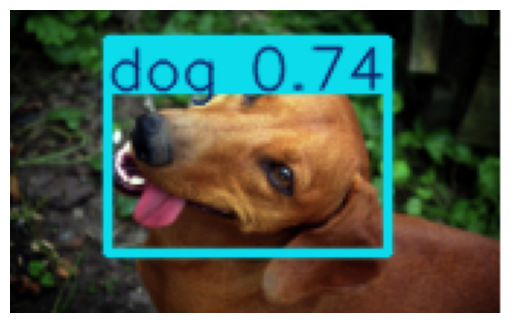


image 1/1 /home/hunt3041/PikaVision/test_images/the_drone.jpg: 384x640 1 drone, 13.4ms
Speed: 4.3ms preprocess, 13.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


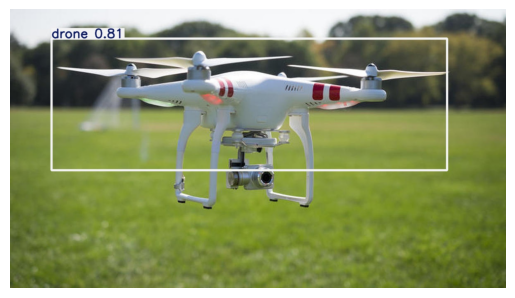


image 1/1 /home/hunt3041/PikaVision/test_images/the_person.png: 448x640 3 persons, 18.1ms
Speed: 1.8ms preprocess, 18.1ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


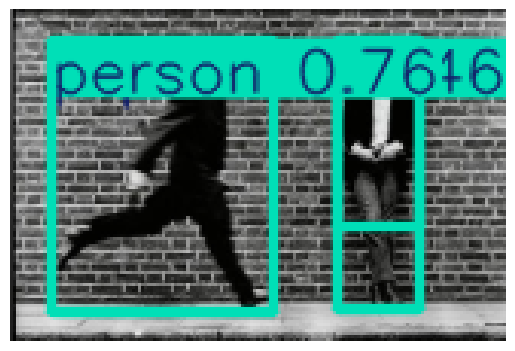


image 1/1 /home/hunt3041/PikaVision/test_images/the_pikachu.jpeg: 320x640 1 pikachu, 13.2ms
Speed: 1.4ms preprocess, 13.2ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


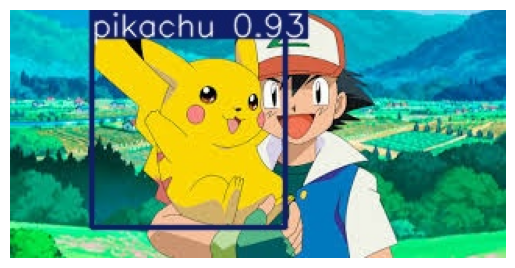


image 1/1 /home/hunt3041/PikaVision/test_images/dog2.jpg: 640x480 1 dog, 17.7ms
Speed: 1.9ms preprocess, 17.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


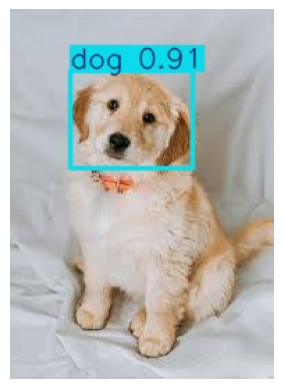


image 1/1 /home/hunt3041/PikaVision/test_images/person2.jpg: 384x640 1 person, 13.8ms
Speed: 1.8ms preprocess, 13.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


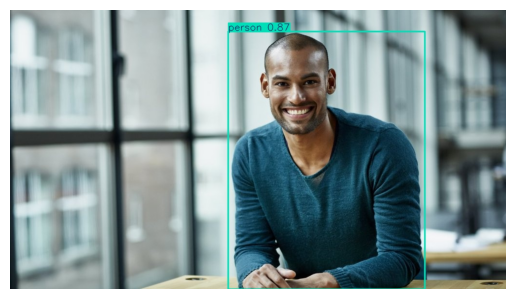

In [18]:
best_model = YOLO(path_to('runs', 'detect', '5_categories_no_aug', 'weights', 'best.pt'))
test_model(best_model, 'the_cat.png')
test_model(best_model, 'the_dog.png')
test_model(best_model, 'the_drone.jpg')
test_model(best_model, 'the_person.png')
test_model(best_model, 'the_pikachu.jpeg')
test_model(best_model, 'dog2.jpg')
test_model(best_model, 'person2.jpg')

In [ ]:
# Load custom model
new_model = YOLO(path_to('runs', 'detect', '5_categories_no_aug', 'weights', 'best.pt'))


image 1/1 /home/hunt3041/PikaVision/test_images/the_cat.png: 384x640 1 cat, 13.9ms
Speed: 2.0ms preprocess, 13.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


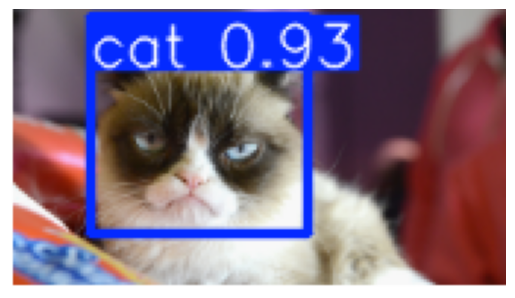


image 1/1 /home/hunt3041/PikaVision/test_images/the_dog.png: 416x640 1 dog, 7.4ms
Speed: 1.0ms preprocess, 7.4ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


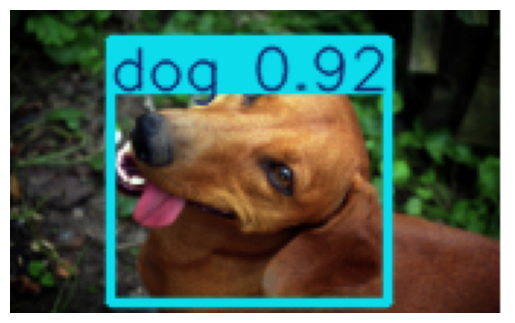


image 1/1 /home/hunt3041/PikaVision/test_images/the_drone.jpg: 384x640 1 drone, 5.5ms
Speed: 1.1ms preprocess, 5.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


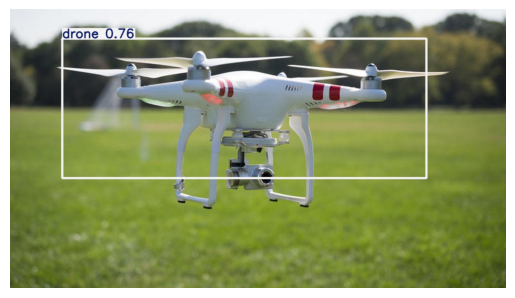


image 1/1 /home/hunt3041/PikaVision/test_images/the_person.png: 448x640 3 persons, 5.9ms
Speed: 1.6ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


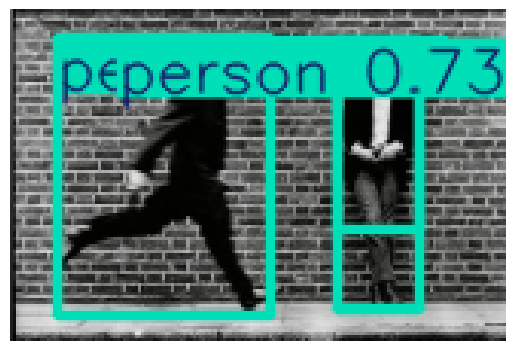


image 1/1 /home/hunt3041/PikaVision/test_images/the_pikachu.jpeg: 320x640 1 pikachu, 6.2ms
Speed: 0.9ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


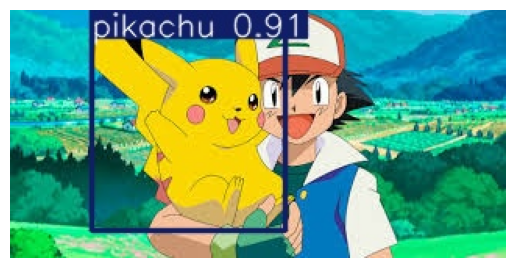


image 1/1 /home/hunt3041/PikaVision/test_images/dog2.jpg: 640x480 1 dog, 7.8ms
Speed: 1.0ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)


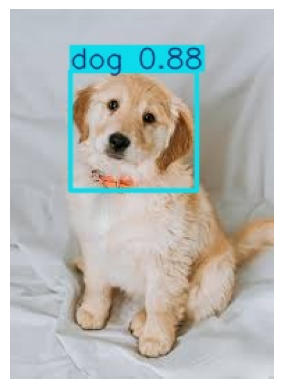


image 1/1 /home/hunt3041/PikaVision/test_images/person2.jpg: 384x640 1 person, 5.6ms
Speed: 1.1ms preprocess, 5.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


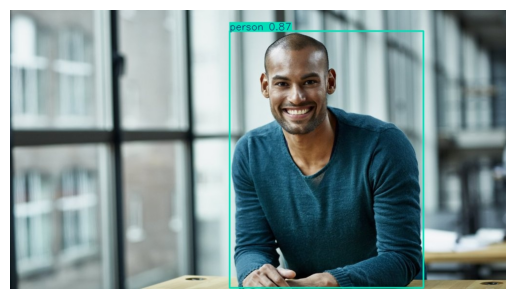

In [19]:
# test custom model
test_model(new_model, 'the_cat.png')
test_model(new_model, 'the_dog.png')
test_model(new_model, 'the_drone.jpg')
test_model(new_model, 'the_person.png')
test_model(new_model, 'the_pikachu.jpeg')
test_model(new_model, 'dog2.jpg')
test_model(new_model, 'person2.jpg')

In [14]:
results = new_model.val(data=path_to('project2-dataset-5', 'data.yaml'))

Ultralytics 8.3.34 🚀 Python-3.8.10 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)


val: Scanning /home/hunt3041/PikaVision/project2-dataset-5/valid/labels.cache... 1946 images, 241 backgrounds, 0 corrupt: 100%|██████████| 1946/1946 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 122/122 [00:12<00:00,  9.64it/s]


                   all       1946       2115      0.969      0.925      0.968      0.817
                   cat        254        257      0.991      0.992      0.994      0.929
                   dog        495        495      0.988      0.986      0.994      0.862
                 drone        469        499      0.976      0.971      0.991      0.707
                person        357        728      0.932      0.758      0.895      0.742
               pikachu        130        136      0.958      0.919      0.967      0.847
Speed: 0.2ms preprocess, 3.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val
